In [38]:
import pandas as pd
import numpy as np
from rdkit.Chem import AllChem
from scripts.butina_clustering import ButinaClustering
from scripts.umap_visualizer import UMAPVisualizer
from scripts.data_processing import Preprocessing
from scripts.analyzing_mixed_cluster import visualize_mixed_clusters, draw_cluster_mol, get_nat_syn_mapping, draw_molecules, analyze_mixed_clusters
import matplotlib.pyplot as plt
from PIL import Image

Cluster-based methods are used to identify the groups or clusters of similar objects in multivariate datasets [1]. In brief, cluster analysis is a technique used in data science and statistical analysis to group a set of objects based on their attributes into clusters. These clusters represent subsets of objects that are more similar to each other than to objects in other clusters.

From such a clustering, a diverse set of compounds can also be selected from a larger set of screening compounds for further experimental testing.
In order to perform machine-learning techniques or statistical analysis on molecules, we need to convert molecules into mathematical objects like vectors. Molecular fingerprints essentially encode molecular features or fragments in the form of a binary digit (0 or 1). If a certain feature is found in a molecular structure, the bit is 0 or 1.

On the other hand, in molecular graphs, atoms are represented as nodes, and bonds between atoms are represented as edges.

Graphs and fingerprints can be used for clustering analysis. According to this [2], they did not find any solid evidence of whether one approach is better than others. Each approach has its own strength and weakness. For this assignment, we will use conventional fingerprint-based data along with the functional or activity-based data to find the similarities between the compounds to identify substitutes.

Structural fingerprints, such as the 1024-bit Morgan fingerprint, offer several advantages over other molecular representations for clustering tasks, as they are computationally efficient and can be easily applied to large datasets [3]. In this project we will use Morgan fingerprints for the molecular representation.

Compound clustering in pharmaceutical research is often based on chemical or structural similarity between compounds to find groups that share properties as well as to design a diverse and representative set for further analysis. There are a number of clustering algorithms available, with the Butina [4] clustering being one of the most widely used algorithms in the pharmaceutical context. Butina uses pairwise Tanimoto similarity [5] to form chemically meaningful clusters by grouping molecules that are all above a user-defined similarity threshold with a central compound. This method is advantageous because it does not assume spherical cluster shapes and is more compatible with the nature of chemical space and fingerprint-based representations. On the other hand, algorithms like K-means are not ideal for this kind of fingerprint-based representation, as K-means uses Euclidean distance as a similarity measure. Also, this kind of algorithm requires assumptions of clusters, which is quite difficult to guess for this dataset.

Our dataset is around 700k. For this big data, it is resource-constrained to run the butina on the whole dataset. As in Butina, we need to load all the distance matrices into the memory. For running the whole dataset, we looked up the algorithms that work best in this kind of situation. Balanced Iterative Reducing and Clustering using Hierarchies, also known as BIRCH, are memory-efficient clustering algorithms using which we can cluster large datasets by first producing a brief summary about the dataset that preserves information as much as possible. Then, instead of the whole dataset, this whole summary is clustered. The major drawback of BIRCH is that it only considers metric attributes. With BIRCH, we managed to run 100k of natural compounds data.

Synthetic products are harmful for the health and environment. People are looking forward to substituting the synthetic product with the natural product. In this assignment, we will identify the natural compounds structurally similar to synthetic compounds for potential substitution.


# Butina Clustering


### Data Loading


Due to resource constraints, we selected 50,000 natural compounds from a pool of 700K.


In [59]:
def get_config(file_name):
    """This is the configuration file"""
    with open(file_name, 'r', encoding='UTF-8') as stream:
        config = yaml.safe_load(stream)
    return config

In [2]:
config = get_config('./config.yaml')

# Load and preprocess data
natural_df = pd.read_csv(config['natural'], sep='\t', nrows=50000)
synthetic_df = pd.read_csv(config['synthetic'], sep='\t')

### Data Processing


The goal is to create a complete feature matrix that includes both molecular fingerprints and chemical properties extracted from molecular representation. But as we want to find the structurally similar compounds, and the descriptors are calculated from the structure. For this reason, we did not include them in further analysis. Additionally, we don't have information about the biological properties of the synthetic compounds we aim to substitute. As a result, our analysis focuses on structural similarities, using molecular fingerprints to assess similarity between compounds. In the preprocessing class, we looked at the data. The natural compounds had quite number of names missing. We only impute them by replacing the nan with not specified. we could have extracted them from the PubChem using their canonical smile. But for now, we decided not to do that and focus on our clustering.


In [3]:
syn_process = Preprocessing(synthetic_df)
syn_feat_df = syn_process.get_features('morgan')

In [4]:
nat_process = Preprocessing(natural_df)
nat_feat_df = nat_process.get_features('morgan')

In [5]:
# For analysis we need to combine all the fingerprints of natural and synthetic
comb_fet = pd.concat([syn_feat_df, nat_feat_df], ignore_index=True, axis=0)
comb_fet['compound_type'] = ['synthetic'] * \
    len(syn_feat_df) + ['natural']*len(nat_feat_df)
all_fps = np.vstack([syn_feat_df.iloc[:, 4:1023], nat_feat_df.iloc[:, 4:1023]])
all_fps = [AllChem.DataStructs.CreateFromBitString(
    ''.join(map(str, row))) for row in all_fps]

### Clustering


As mentioned earlier, we used the Butina algorithm for clustering. `Similarity_threshold` plays a vital role in Butina clustering. It defines the maximum distance (or minimum similarity) allowed between molecules to be grouped into the same cluster. Lower value means smaller clusters while larger value means the clusters will be large in size.


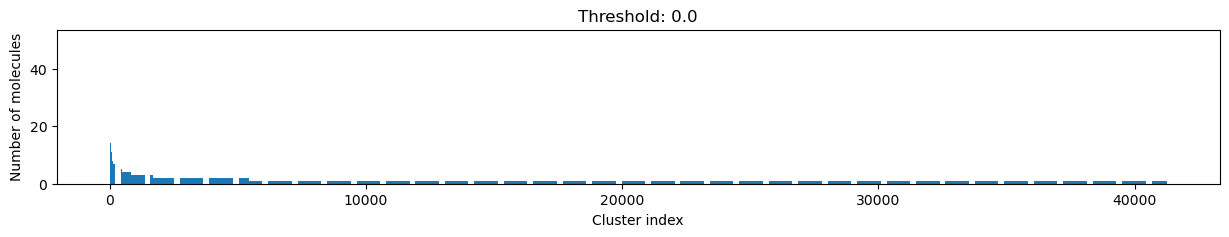

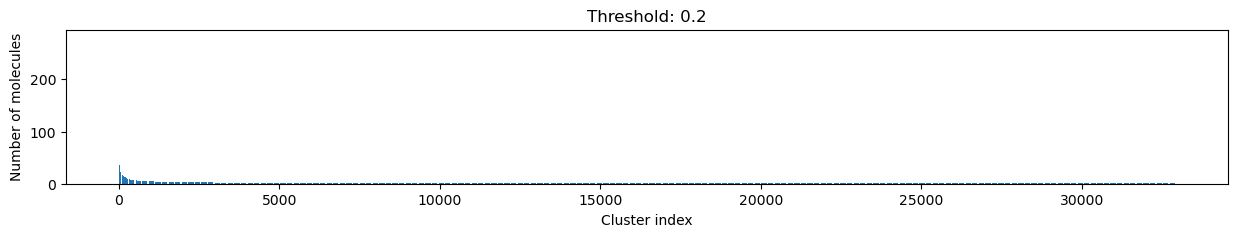

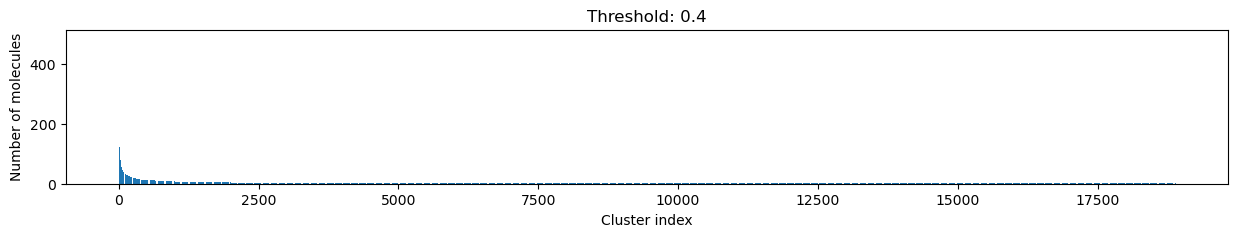

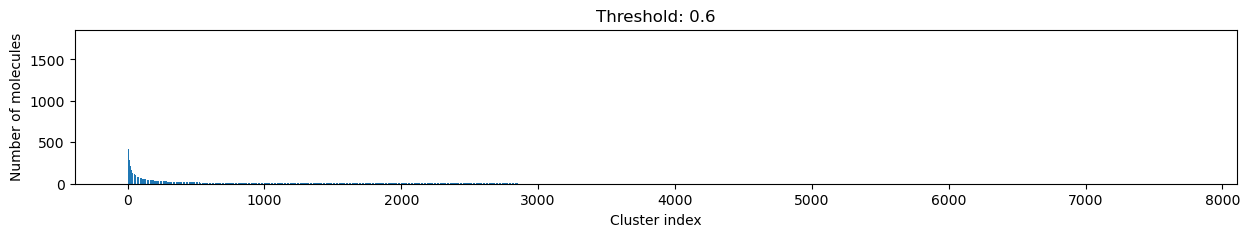

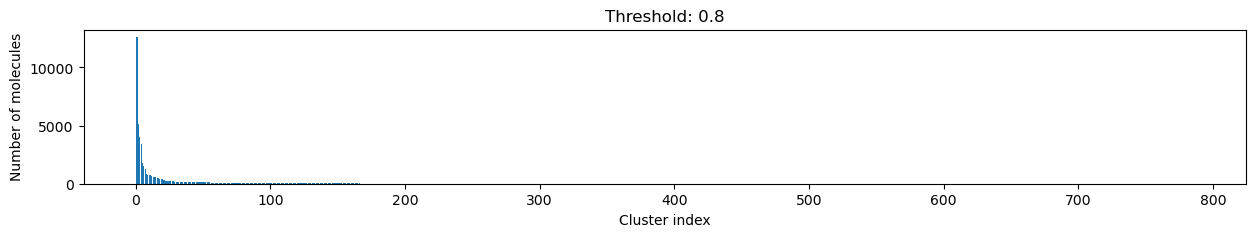

In [34]:

def cluster_thresholds(finger_print_data):
    """
    inspired from https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html
    
    """
     
    butina_cluster_stats = []
    for threshold in np.arange(0.0, 1.0, 0.2):
        butina = ButinaClustering(finger_print_data = finger_print_data, similarity_threshold = threshold)
        butina.clustering()
        clusters = butina.clusters_
        stat = butina.cluster_stats_
        stat['threshold'] = threshold
        butina_cluster_stats.append(butina.cluster_stats_)
        plt.figure(figsize=(15, 2))
        plt.title(f"Threshold: {threshold:3.1f}")
        plt.xlabel("Cluster index")
        plt.ylabel("Number of molecules")
        plt.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
        plt.show()
    return butina_cluster_stats

butina_cluster_stats = cluster_thresholds(all_fps)

### Cluster Stats of different threshold values


In [29]:
butina_cluster_stats_df = pd.DataFrame(butina_cluster_stats)
butina_cluster_stats_df.index = butina_cluster_stats_df['threshold']
butina_cluster_stats_df


,total_clusters,total_compounds,singleton_clusters,doubleton_clusters,tripleton_clusters,quadrupleton_clusters,clusters_gt5,clusters_gt25,clusters_gt100,average_cluster_size,median_cluster_size,max_cluster_size,min_cluster_size,size_distribution,threshold
threshold,,,,,,,,,,,,,,,
0.0,41252,50921,35827,3738,855,356,289,8,0,1.234389,1.0,51,1,"[51, 51, 49, 49, 35, 34, 30, 27, 23, 23, 22, 1...",0.0
0.2,32922,50921,25866,4043,1289,641,753,45,2,1.546716,1.0,281,1,"[281, 101, 82, 75, 67, 65, 64, 59, 55, 54, 50,...",0.2
0.4,18892,50921,12210,2758,1214,704,1567,184,22,2.695374,1.0,490,1,"[490, 430, 308, 254, 247, 172, 172, 171, 159, ...",0.4
0.6,7722,50921,3617,1254,690,411,1469,302,61,6.594276,2.0,1771,1,"[1771, 1658, 743, 681, 631, 442, 419, 418, 373...",0.6
0.8,785,50921,212,104,67,41,330,144,57,64.867516,4.0,12613,1,"[12613, 5133, 4038, 3448, 1776, 1520, 1308, 81...",0.8


### Number of singleton clusters compared to total number of clusters for each thresholds in percentage


In [30]:
butina_cluster_stats_df['singleton_clusters'] / \
    butina_cluster_stats_df['total_clusters'] * 100

threshold
0.0    86.849122
0.2    78.567523
0.4    64.630531
0.6    46.840197
0.8    27.006369
dtype: float64

Based on our experiments, we select `threshold=0.6` as it has smother distribution of clusters and a moderate percentage of singleton cluster compared to others. If we focus more on highest similarities, we will get more single clusters which we want to avoid.


In [10]:
butina = ButinaClustering(finger_print_data=all_fps, similarity_threshold=0.6)
butina.clustering()
comb_fet['cluster_label'] = butina._get_cluster_labels()

### Clustering Results


#### UMAP Visualizer


UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique, similar to t-SNE but faster and often better at preserving both global and local structure.  Since our dataset is large, UMAP is more suitable for visualizing the entire dataset efficiently.

/homes/rmeshita/miniconda3/envs/chemdata/lib/python3.10/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/homes/rmeshita/miniconda3/envs/chemdata/lib/python3.10/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(


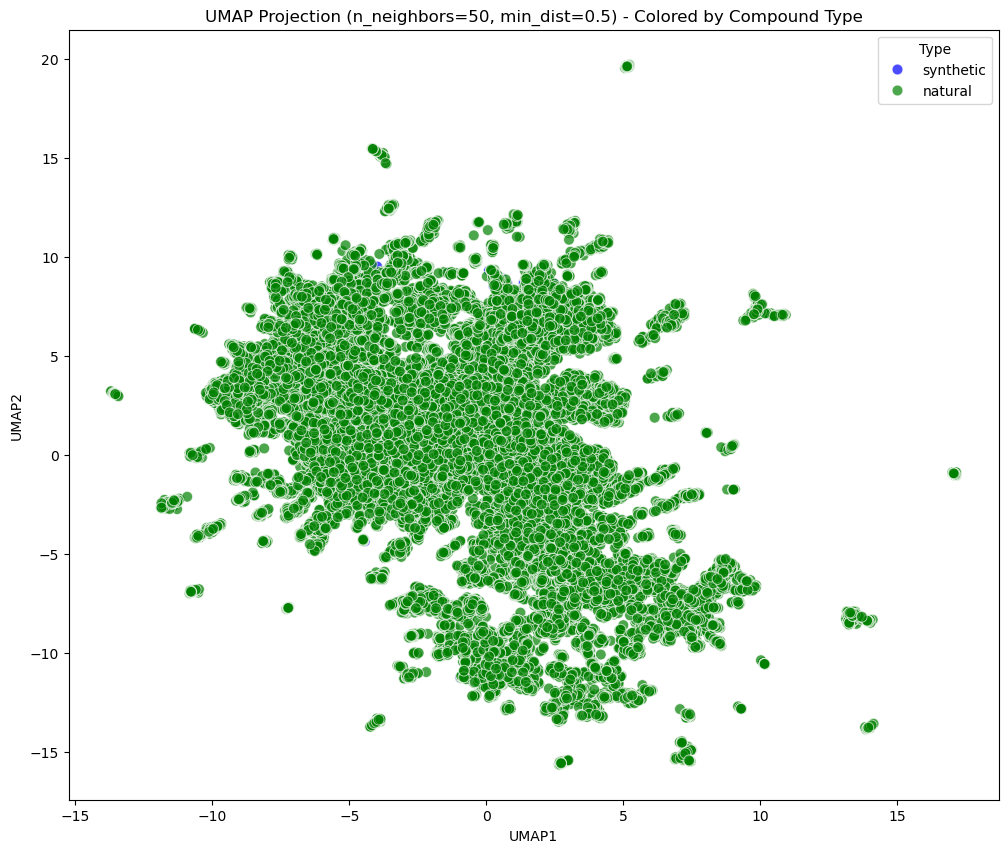

In [49]:
umap_vis = UMAPVisualizer(
    n_neighbors=50,
    min_dist=0.5,
    metric='jaccard'
)
umap_df = umap_vis.run_umap(
    all_fps,
    labels=comb_fet['cluster_label'].values,
    types=comb_fet['compound_type'].values,
    sample_size=None  # as the sample is not big
)

umap_vis.show_plot(umap_df, color_by='type',
                   output_dir="./cluster_results/Butina")

As the size of the natural compound is more, they completely outnumbered the synthetics compounds and made it impossible to separate them. 

#### Intra-cluster Similarity


Intra-cluster Tanimoto similarity measures how similar the molecules are **within the same cluster**, based on their fingerprint overlap. A higher average intra-cluster similarity means the molecules in that cluster share more structural features and are more homogeneous. Due large number of clusters, we decided to visualize only larger clusters,like cluster that have more than 200 or 100 molecules.


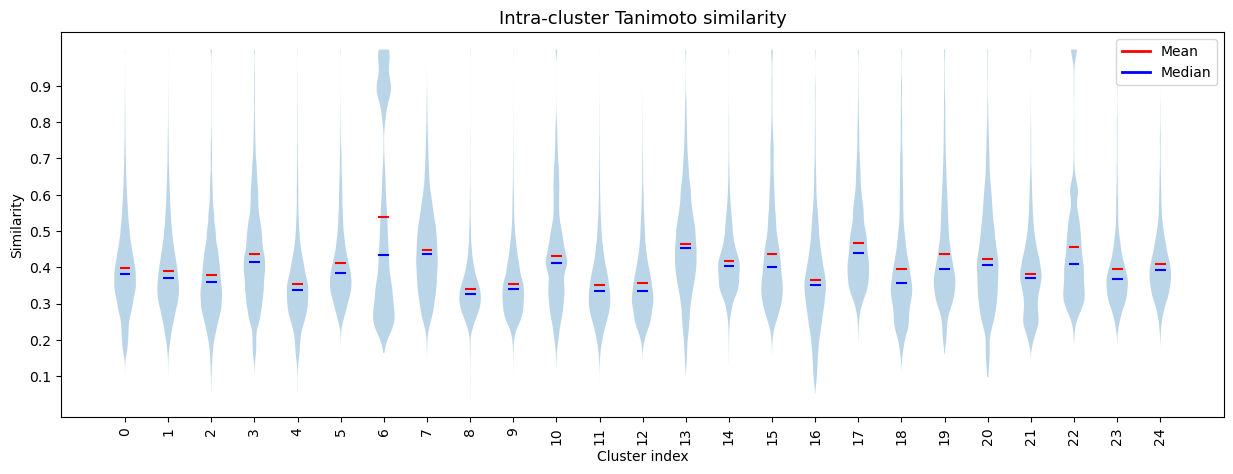

In [24]:
butina.plot_intra_cluster_similarity(
    min_clusters=200, output_file="./cluster_results/Butina/intra_similarities_200.png")

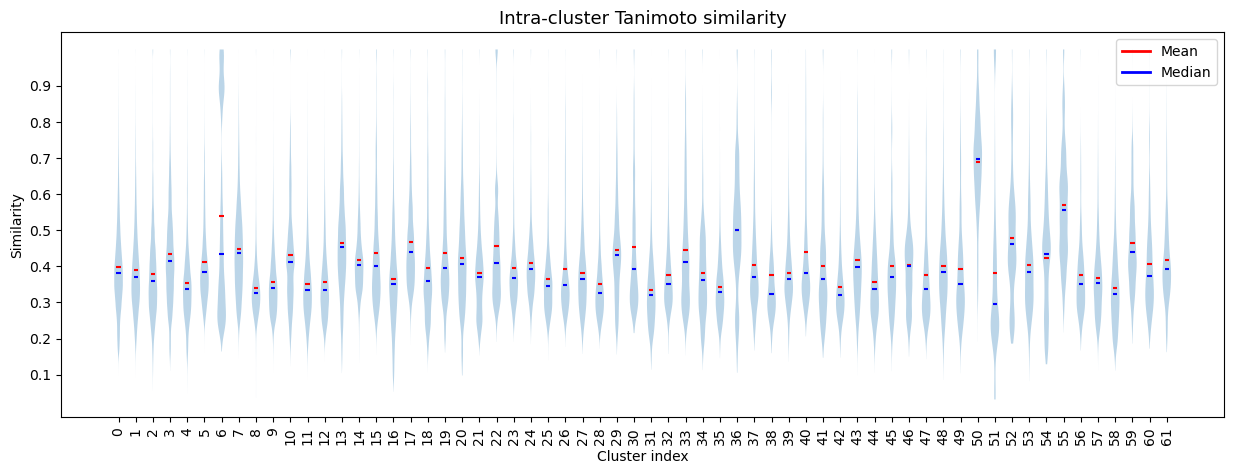

In [25]:
butina.plot_intra_cluster_similarity(
    min_clusters=100, output_file="./cluster_results/Butina/intra_similarities_100.png")

In both plot , we could see mean and median are close together. It means that distribution of the similarity score within a clusters are similar. When the the number of molecules are 100, the violin plots are spiked, showing they have a tight distribution. As the number of molecules increase, the average similarity score decrease or becomes variable meaning not consistent. 

#### Analyze Mixed Clusters


In this section, we separated natural and synthetic compounds that belong to the same cluster, based on the assumption that they share similar features. This approach allows us to filter and identify potential natural alternatives to synthetic compounds.


In [14]:
mixed_cluster = analyze_mixed_clusters(comb_fet, 'cluster_label')

We further refined the clusters to identify suitable alternatives to synthetic compounds. For each cluster, we performed pairwise Tanimoto similarity comparisons between natural and synthetic compounds, selecting only those pairs where the similarity exceeded a defined threshold. By default, this threshold was set to 0.9. As we want the compounds to be structurally similar, that's why set the high threshold.


In [15]:
mappings = get_nat_syn_mapping(mixed_cluster, comb_fet, threshold=0.9)
mappings_df = pd.DataFrame(mappings)
mappings_df.index = mappings_df['synthetic_comp']

In [16]:
mappings_df.head()

,relations,cluster,synthetic_comp,similarity
synthetic_comp,,,,
oleanolic acid,"[OLEANOLIC ACID, (4aS,6aR,6aS,6bR,8aR,10S,12aR...",0,oleanolic acid,1.000000
glycyrrhizic acid,"[LMPR0106150013, Glycyrrhizic acid, CS-W019908...",0,glycyrrhizic acid,0.991342
arbutin,"[(2S,3S,4R,5S,6S)-2-(hydroxymethyl)-6-(4-hydro...",1,arbutin,1.000000
rutin,"[1340-08-5, RUTIN, Quercetin 3-robinobioside, ...",1,rutin,1.000000
esculin,"[Cichoriin, Esculin]",1,esculin,0.965116


### Draw Molecules


We have drawn molecules of alternatives of synthetics compounds. We used `MolsToGridImage` from `RDKit` that takes a list of RDKit molecule objects (Mol) and arranges them in a grid, rendering 2D images of the molecules. This helps use visualize the structure of synthetic compounds and its potential alternative natural compounds.


In [26]:
draw_molecules(mappings_df, comb_fet, "./cluster_results/Butina/alternatives")

We have also drawn the molecules of top 10 mixed clusters in png files


In [ ]:
visualize_df = visualize_mixed_clusters(
    comb_fet, mixed_cluster, output_dir="./cluster_results/Butina")
draw_cluster_mol(butina.clusters_, visualize_df, comb_fet,
                 "./cluster_results/Butina/clustered_images")

In [55]:
def show_image(path):
    img = Image.open(path)
    plt.figure(figsize=(18, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

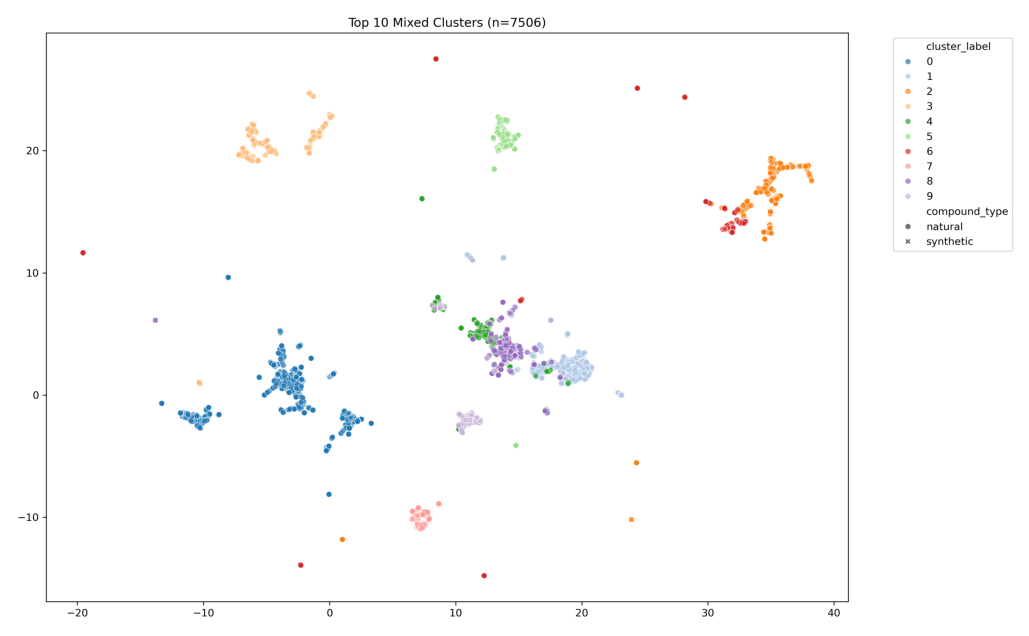

In [57]:
show_image('./cluster_results/Butina/mixed_clusters_umap.png')

The mixed cluster visualization and the per-cluster natural and synthetic compounds grid image are saved in the `clusterd_image`s directory. From the image, it is shown that molecules clustered together are structurally similar. In some cases, such as with `phloridzin` and `phlorizin`, isomers are grouped together. This is because isomers share the same structure, with only the orientation of atoms differing.

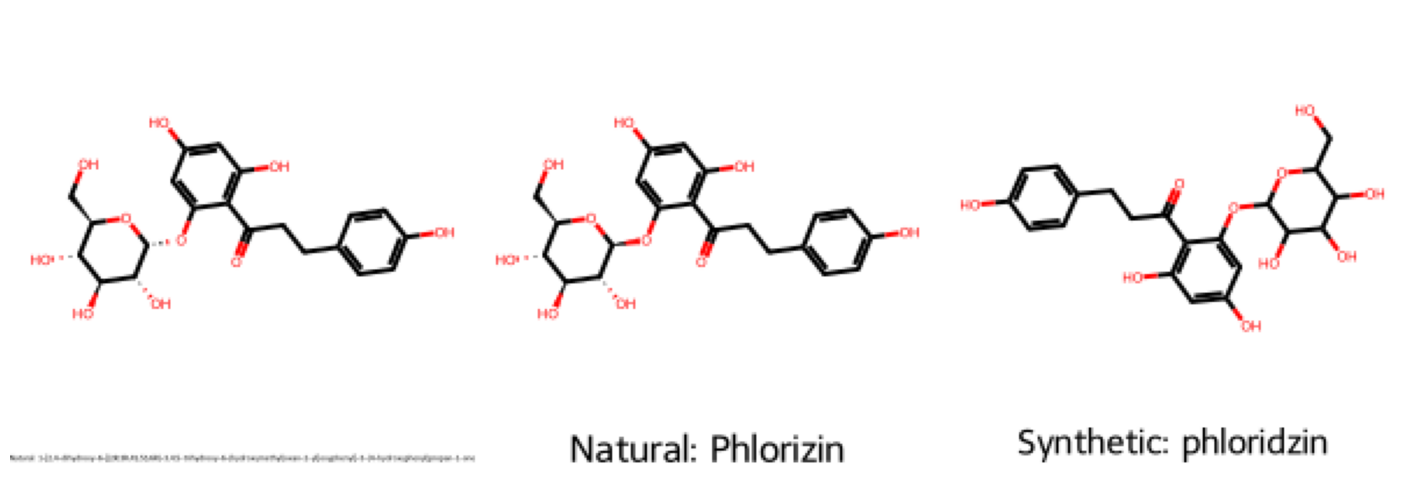

In [58]:
show_image('./cluster_results/Butina/alternatives/phloridzin.png')

### Conclusion


Structural similarity analysis allows us to successfully identify compounds with similar molecular frameworks, as evidenced by high Tanimoto similarity scores. Using the Butina clustering algorithm with molecular fingerprints provides an effective method for grouping structurally similar compounds.
However, Butina clustering faces significant computational limitations with large chemical libraries. Processing just 50,000 compounds requires approximately 80 minutes, while scaling to 700,000 compounds would demand over 17 hours of computation time. These performance constraints stem from the algorithm's requirement to calculate all pairwise similarities between compounds, a process that resists efficient parallelization.
More importantly, structural similarity alone proves insufficient for identifying true molecular substitutes. While structural similarity models excel at screening and prioritization tasks [7], finding functional substitutes demands a more comprehensive approach. To identify genuine replacements, we must consider additional parameters beyond structural properties, such Biological profiles, functional group analysis, and experimental data.


# BIRCH Clustering




Besides Butina, we have also experimented with the BIRCH clustering algorithm (Balanced Iterative Reducing and Clustering using Hierarchies). Although BIRCH is designed to be memory-efficient for large datasets, our implementation still faced significant computational challenges. Processing just 100,000 compounds required approximately 4 hours of computation time, while scaling to our full dataset of 700,000 compounds would demand over 17 hours. To run the BIRCH clustering algorithm, you can execute the script `birch.py` located in the script folder. We did not perform the same extensive analysis and optimization for BIRCH as we did for the Butina algorithm.

#### Top 10 mixed cluster generated from BIRCH Clustering

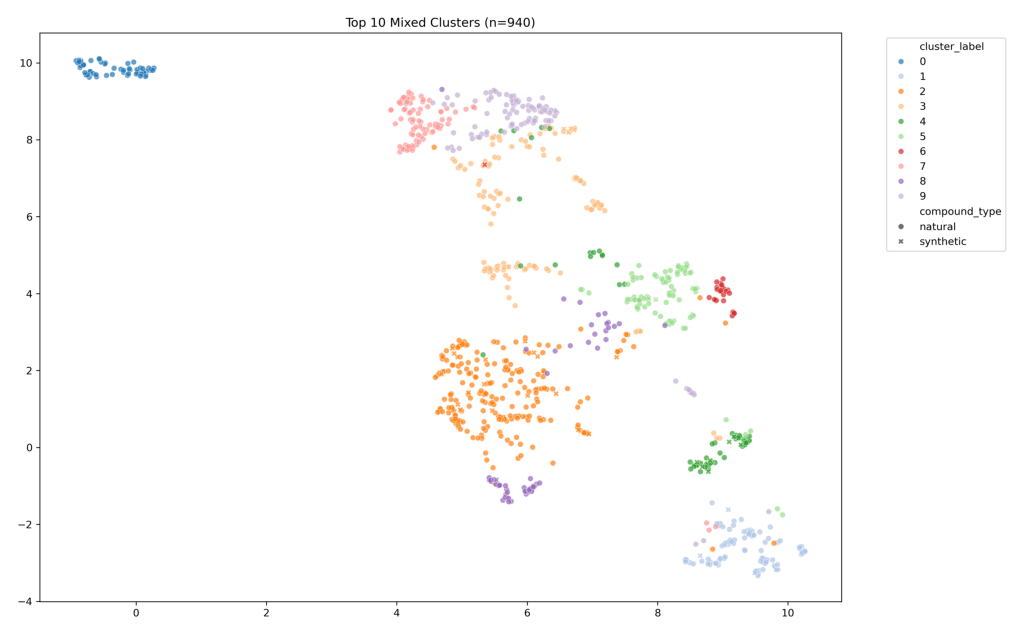

In [64]:
show_image('./cluster_results/Birch_cluster/mixed_clusters_umap.png')

Compared to Butina, we observe more overlapping clusters in BIRCH. However, with BIRCH the clusters are more compact. 

# References:

[1] B.S. Everitt, Cluster Analysis, 3rd ed., Arnold, London, 1993.

[2] Raymond JW, Blankley CJohn, Willett P. Comparison of chemical clustering methods using graph- and fingerprint-based similarity measures. Journal of molecular graphics & modelling/Journal of molecular graphics and modelling. 2003 Mar 1;21(5):421–33

‌[3] Hernández-Hernández, S., & Ballester, P. J. (2023). On the best way to cluster NCI-60 molecules. Biomolecules, 13(3), 498. doi:10.3390/biom13030498

[4] Butina, D. (1999). Unsupervised data base clustering based on daylight’s fingerprint and tanimoto similarity: A fast and automated way to cluster small and large data sets. Journal of Chemical Information and Computer Sciences, 39(4), 747–750. doi:10.1021/ci9803381

[5] Bajusz, D., Rácz, A., & Héberger, K. (2015). Why is Tanimoto index an appropriate choice for fingerprint-based similarity calculations? Journal of Cheminformatics, 7(1), 20. doi:10.1186/s13321-015-0069-3

[6] National Center for Biotechnology Information. (n.d.). PubChem. National Library of Medicine. Retrieved April 19, 2025, from https://pubchem.ncbi.nlm.nih.gov

[7] Wassenaar, P. N. H., Rorije, E., Vijver, M. G., & Peijnenburg, W. J. G. M. (2021). Evaluating chemical similarity as a measure to identify potential substances of very high concern. Regulatory Toxicology and Pharmacology: RTP, 119(104834), 104834. doi:10.1016/j.yrtph.2020.104834